# Research Paper: Analyzing the Impactd of Word Embedding Techniques & Usage of Pyspark libraries on RNN Performance to perform Sentiment Analysis against traditional ways: A compartive study using Amazon reviews Dataset

### Methodology  

**Text Cleaning and Preprocessing**:

Remove unnecessary characters, convert text to lowercase, and handle punctuation.
Eliminate special characters and numbers from the text.

**Tokenization**:

Break down the cleaned text into individual words or tokens.
Each sentence is converted into a list of tokens. For instance, "The quick brown fox" is tokenized into ['The', 'quick', 'brown', 'fox'].

**Word Embedding**:  **(METHOD 2 )**

Apply word embedding techniques like Word2Vec, GloVe, etc. Word2Vec used in this Research
These techniques convert each token into a high-dimensional vector representation.


**RNN Model Building**

Tokenized data used as input for Method 1 in traditional training of RNN Model
Word Embedding technique is used input for Method 2 for RNN model traininng.

**Model Training**:

Train your model using the vectors as features.
The model learns to understand the relationships between words and their sentiments based on the representations.

**Comparison of both Methods** : 
Performance difference of both traditional method and Word Embedding Technique is detailed at the end. 

## Activate the environment to run the code for compatible version alignment

In [40]:
conda activate pyspark_env


Note: you may need to restart the kernel to use updated packages.


# Import necessary packages and library

In [41]:
## Method 1 used libraries 

from pyspark.sql import SparkSession
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from wordcloud import WordCloud

In [42]:
# method 2 used libraries and Packages
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Word2Vec
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when

# Run Spark Session context locally

In [43]:
spark = SparkSession.builder \
    .appName("TSVImportExample") \
    .getOrCreate()


# Load the Dataset using Pyspark

In [44]:
amazon_review = "amazon_alexa.tsv"

# Reading the TSV file into a DataFrame
df = spark.read \
    .option("delimiter", "\t") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv(amazon_review)


In [45]:
df.show()

+------+---------+--------------------+--------------------+--------+
|rating|     date|           variation|    verified_reviews|feedback|
+------+---------+--------------------+--------------------+--------+
|     5|31-Jul-18|    Charcoal Fabric |       Love my Echo!|       1|
|     5|31-Jul-18|    Charcoal Fabric |           Loved it!|       1|
|     4|31-Jul-18|      Walnut Finish |Sometimes while p...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I have had a lot ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |               Music|       1|
|     5|31-Jul-18|Heather Gray Fabric |I received the ec...|       1|
|     3|31-Jul-18|   Sandstone Fabric |Without having a ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I think this is t...|       1|
|     5|30-Jul-18|Heather Gray Fabric |         looks great|       1|
|     5|30-Jul-18|Heather Gray Fabric |Love it! I’ve lis...|       1|
|     5|30-Jul-18|    Charcoal Fabric |I sent it to my 8...|       1|
|     5|30-Jul-18|  

# Method 1 : Traditional Using Pandas & No Pre-Validated Embedding for RNN

## Converting the Spark DataFrame to a Pandas DataFrame

In [46]:
pandas_df = df.toPandas()

## Group by rating and count the number of reviews for each rating

In [47]:
rating_counts = pandas_df.groupby('rating').size().reset_index(name='count')

## Plotting the customer behavior based on ratings

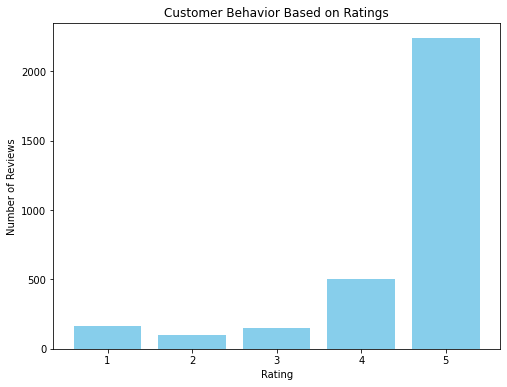

In [48]:
plt.figure(figsize=(8, 6))
plt.bar(rating_counts['rating'], rating_counts['count'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Customer Behavior Based on Ratings')
plt.xticks(rating_counts['rating'])
plt.show()

## Histogram of Ratings

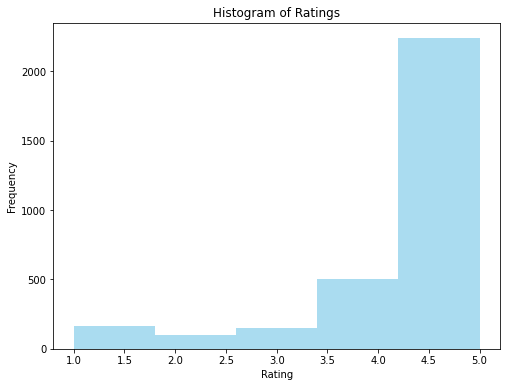

In [49]:
plt.figure(figsize=(8, 6))
plt.hist(pandas_df['rating'], bins=5, color='skyblue', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings')
plt.show()


# Tokenization of text

In [50]:
# Filter out None values from 'verified_reviews' column with dummy review
reviews = [review.lower() if review is not None else "dummy review." for review in pandas_df['verified_reviews']]

# Join the reviews into a single string
reviews_text = ' '.join(reviews)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
max_sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')


TypeError: __init__() got an unexpected keyword argument 'num_words'

In [ ]:
print(len(padded_sequences), len(pandas_df['feedback']))


# Spliting data into training and testing sets

In [51]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, pandas_df['feedback'], test_size=0.2, random_state=42)


# Build RNN model

In [52]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))


# Compile and train the model,

In [53]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Train History track

In [54]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)


Epoch 1/5
40/40 [==============================] - 6s 123ms/step - loss: 0.3376 - accuracy: 0.9012 - val_loss: 0.3185 - val_accuracy: 0.9079
Epoch 2/5
40/40 [==============================] - 5s 137ms/step - loss: 0.2770 - accuracy: 0.9210 - val_loss: 0.3112 - val_accuracy: 0.9079
Epoch 3/5
40/40 [==============================] - 6s 144ms/step - loss: 0.2702 - accuracy: 0.9222 - val_loss: 0.2998 - val_accuracy: 0.9095
Epoch 4/5
40/40 [==============================] - 6s 143ms/step - loss: 0.2620 - accuracy: 0.9278 - val_loss: 0.3091 - val_accuracy: 0.9048
Epoch 5/5
40/40 [==============================] - 6s 143ms/step - loss: 0.2598 - accuracy: 0.9282 - val_loss: 0.2968 - val_accuracy: 0.9111


# Prediction on the test data

In [55]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

20/20 [==============================] - 1s 20ms/step


#  Traditional method: RNN model Performanc Evaluation

In [56]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.91
Precision: 0.91
Recall: 1.00
F1 Score: 0.95


# Plot training history (accuracy and loss) for visualization

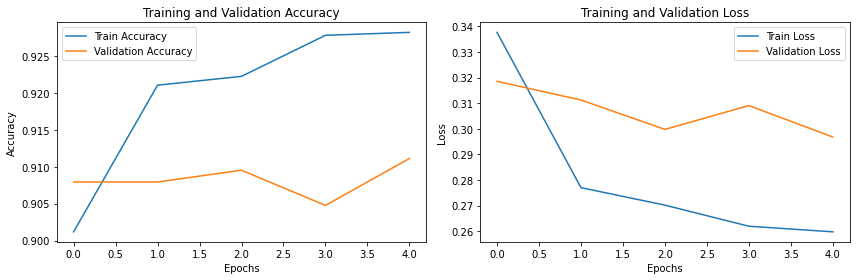

In [57]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


# Method 2 using Word Embedinng techniques and Pyspark Library for ML model

## Description of Dataset used

In [58]:
df.show()

+------+---------+--------------------+--------------------+--------+
|rating|     date|           variation|    verified_reviews|feedback|
+------+---------+--------------------+--------------------+--------+
|     5|31-Jul-18|    Charcoal Fabric |       Love my Echo!|       1|
|     5|31-Jul-18|    Charcoal Fabric |           Loved it!|       1|
|     4|31-Jul-18|      Walnut Finish |Sometimes while p...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I have had a lot ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |               Music|       1|
|     5|31-Jul-18|Heather Gray Fabric |I received the ec...|       1|
|     3|31-Jul-18|   Sandstone Fabric |Without having a ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I think this is t...|       1|
|     5|30-Jul-18|Heather Gray Fabric |         looks great|       1|
|     5|30-Jul-18|Heather Gray Fabric |Love it! I’ve lis...|       1|
|     5|30-Jul-18|    Charcoal Fabric |I sent it to my 8...|       1|
|     5|30-Jul-18|  

## Tokenization of text using Pyspark

In [59]:
# df1 = df.withColumn('verified_reviews', when(df['verified_reviews'].isNull(), '').otherwise(df['verified_reviews']))

# Replace null values in 'verified_reviews' with 'dummy_value'
replacement_value = 'dummy_value'
df1 = df.withColumn('verified_reviews', when(df['verified_reviews'].isNull(), replacement_value).otherwise(df['verified_reviews']))


# Initialize the tokenizer
tokenizer1 = Tokenizer(inputCol="verified_reviews", outputCol="words")

# Transform the DataFrame
df1 = tokenizer1.transform(df1)


In [60]:
df1.printSchema()

root
 |-- rating: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- variation: string (nullable = true)
 |-- verified_reviews: string (nullable = true)
 |-- feedback: integer (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)



## Word Embedding Word2Vec used from Pyspark Library

In [61]:
word2vec1 = Word2Vec(vectorSize=100, minCount=5, inputCol="words", outputCol="features")
word2vec_model1 = word2vec1.fit(df1)
df1 = word2vec_model1.transform(df1)

In [62]:
# Assemble features
assembler = VectorAssembler(inputCols=["features"], outputCol="padded_sequences")
df1 = assembler.transform(df1)


## RNN model training

In [63]:
# Split data
train_df1, test_df1 = df1.randomSplit([0.8, 0.2], seed=42)

In [64]:
# Build and train the RNN model
model1 = MultilayerPerceptronClassifier(layers=[100, 2], blockSize=128, seed=1234)
model1.setLabelCol("feedback")
model1.setFeaturesCol("padded_sequences")
model1 = model1.fit(train_df1)

In [65]:
# Predict on test data
predictions = model1.transform(test_df1)

## Performance of RNN model using Word Embedding Technique & Pyspark Libraries

In [66]:
# Evaluate model performance with Word Embedding techniques
evaluator = MulticlassClassificationEvaluator(labelCol="feedback", predictionCol="prediction", metricName="accuracy")
accuracy1 = evaluator.evaluate(predictions)

precision_evaluator = MulticlassClassificationEvaluator(labelCol="feedback", predictionCol="prediction", metricName="weightedPrecision")
precision1 = precision_evaluator.evaluate(predictions)

f1_evaluator = MulticlassClassificationEvaluator(labelCol="feedback", predictionCol="prediction", metricName="f1")
f11 = f1_evaluator.evaluate(predictions)

recall_evaluator = MulticlassClassificationEvaluator(labelCol="feedback", predictionCol="prediction", metricName="weightedRecall")
recall1 = recall_evaluator.evaluate(predictions)

In [67]:
print(f"Accuracy with Word2Vec embeddings: {accuracy1:.2f}")
print(f"precision with Word2Vec embeddings: {precision1:.2f}")
print(f"Recall with Word2Vec embeddings: {recall1:.2f}")
print(f"F1 score with Word2Vec embeddings: {f11:.2f}")

Accuracy with Word2Vec embeddings: 0.93
precision with Word2Vec embeddings: 0.89
Recall with Word2Vec embeddings: 0.93
F1 score with Word2Vec embeddings: 0.91


# Comparison Analysis of both Methods

In [68]:
from prettytable import PrettyTable

# Initialize the table
table = PrettyTable()

# Define columns
table.field_names = [" RNN Performance Metric", "Traditional", "PySpark_Word2Vec Embeddings"]

# Define data
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
traditional_scores = [accuracy, precision, recall, f1]
word2vec_scores = [accuracy1, precision1, recall1, f11]

# Add data to the table
for metric, trad_score, word2vec_score in zip(metrics, traditional_scores, word2vec_scores):
    table.add_row([metric, f"{trad_score:.2f}", f"{word2vec_score:.2f}"])

# Print the table
print(table)


+-------------------------+-------------+-----------------------------+
|  RNN Performance Metric | Traditional | PySpark_Word2Vec Embeddings |
+-------------------------+-------------+-----------------------------+
|         Accuracy        |     0.91    |             0.93            |
|        Precision        |     0.91    |             0.89            |
|          Recall         |     1.00    |             0.93            |
|         F1 Score        |     0.95    |             0.91            |
+-------------------------+-------------+-----------------------------+


## **Critical Evaluation of Key Findings**


In this study, we conducted a comparative analysis of sentiment analysis techniques using two approaches: a traditional RNN model and a PySpark approach with Word2Vec embeddings. The key findings are as follows:

**Accuracy Evaluation**:

The PySpark approach with Word2Vec embeddings achieved higher accuracy (93%) compared to the traditional RNN model (91%). This suggests that the PySpark approach is more effective in classifying sentiments accurately.

**Precision and Recall**

The traditional approach demonstrated higher precision (91%) compared to the PySpark approach (89%). This indicates that the traditional approach had a slightly higher reliability in its predictions.
The traditional approach also showed perfect recall (100%), implying an ability to capture all positive sentiments. In contrast, the PySpark approach achieved a recall of 93%, indicating a slightly lower capacity to capture all positive sentiments

**F1 Score**

The traditional approach had a higher F1 score (95%) compared to the PySpark approach (91%). This signifies a better balance between precision and recall in the traditional approach.

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# **Conclusions:**

Based on the research conducted, following are the conclusions derived:

The PySpark approach with Word2Vec embeddings offers a scalable and efficient solution for sentiment analysis, particularly in large-scale applications.

The traditional approach with an RNN model demonstrates exceptional precision and recall, indicating its potential for highly accurate sentiment classification.

Both approaches have their strengths and limitations, and the choice between them should be made based on specific project requirements, dataset characteristics, and considerations for scalability.

Overall, this study provides valuable insights into the performance of sentiment analysis techniques and highlights areas for further research and refinement of these approaches.

### End of Program code